# MovieLens Recommender System: Data Science Life Cycle

# 1. Importing Libraries and Dependencies


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNBasic, NormalPredictor, BaselineOnly, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
import os


In [50]:
# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [51]:
# Output directory setup
output_dir = '../output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 2. Data Loading


In [52]:
movies_file = '../data/movies.csv'
ratings_file = '../data/ratings.csv'

In [53]:
movies_df = pd.read_csv(movies_file)
ratings_df = pd.read_csv(ratings_file)

In [54]:
# Preview the data
print(f"Movies Data Shape: {movies_df.shape}")
print(f"Ratings Data Shape: {ratings_df.shape}")


Movies Data Shape: (10329, 3)
Ratings Data Shape: (105339, 4)


In [55]:
print("\nFirst few rows of Movies Data:")
print(movies_df.head())
print("\nFirst few rows of Ratings Data:")
print(ratings_df.head())


First few rows of Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

First few rows of Ratings Data:
   userId  movieId  rating   timestamp
0       1       16    4.00  1217897793
1       1       24    1.50  1217895807
2       1       32    4.00  1217896246
3       1       47    4.00  1217896556
4       1       50    4.00  1217896523


In [56]:
# Merge the datasets on 'movieId'
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')

In [57]:
# Display the merged dataset
print("\nMerged Dataset:")
print(merged_df.head())


Merged Dataset:
   userId  movieId  rating   timestamp          title       genres
0       1       16    4.00  1217897793  Casino (1995)  Crime|Drama
1       9       16    4.00   842686699  Casino (1995)  Crime|Drama
2      12       16    1.50  1144396284  Casino (1995)  Crime|Drama
3      24       16    4.00   963468757  Casino (1995)  Crime|Drama
4      29       16    3.00   836820223  Casino (1995)  Crime|Drama


In [58]:
# Save the merged dataset for future use in visualization and analysis
output_path = '../output/merged_ratings_movies.csv'
merged_df.to_csv(output_path, index=False)

# 3. Exploratory Data Analysis (EDA)

In [9]:
# Check missing values
print(f"\nMissing Values in Movies Data: \n{movies_df.isnull().sum()}")
print(f"\nMissing Values in Ratings Data: \n{ratings_df.isnull().sum()}")


Missing Values in Movies Data: 
movieId    0
title      0
genres     0
dtype: int64

Missing Values in Ratings Data: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


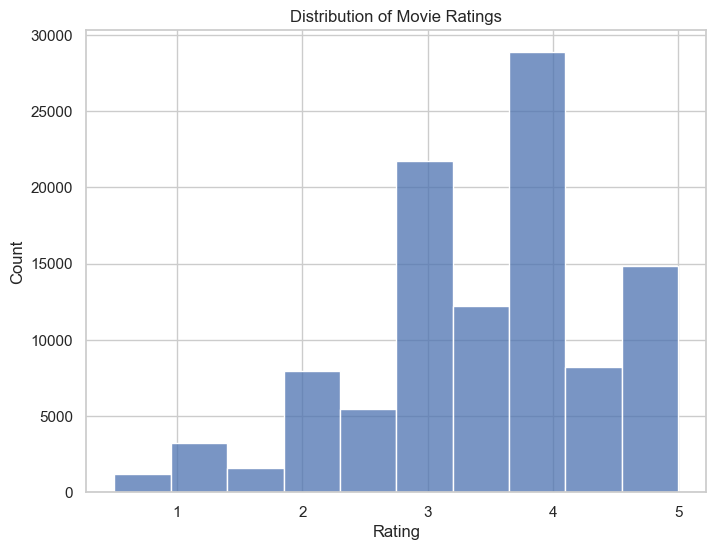

In [59]:
# Univariate Analysis: Distribution of Ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'ratings_distribution.png'))
plt.show()

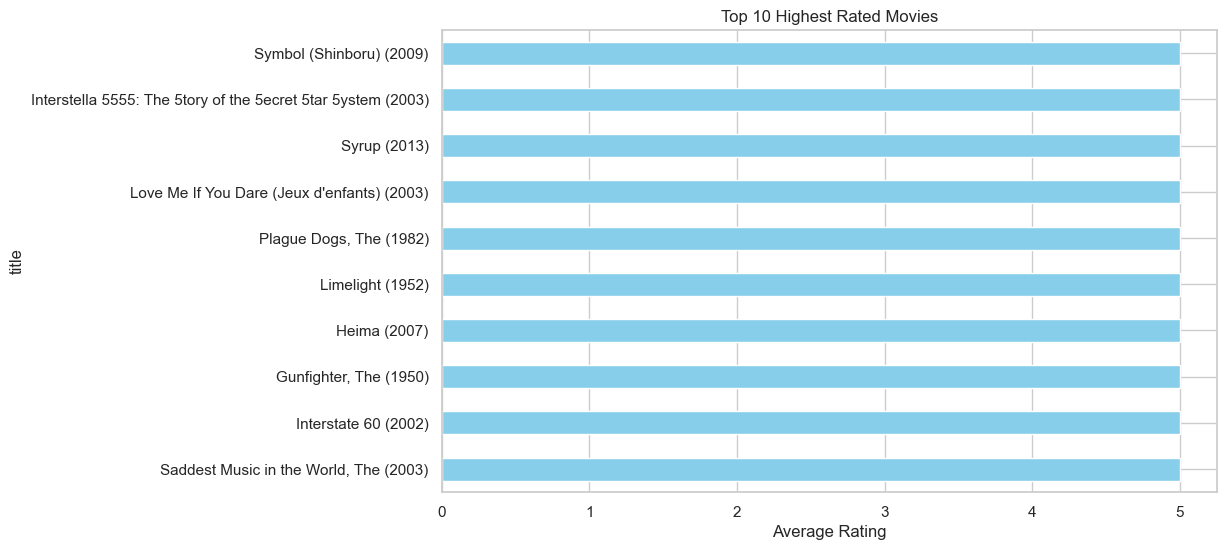

In [60]:
# Bivariate Analysis: Average Rating per Movie
average_ratings = merged_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
average_ratings.plot(kind='barh', color='skyblue')
plt.title('Top 10 Highest Rated Movies')
plt.xlabel('Average Rating')
plt.savefig(os.path.join(output_dir, 'top_rated_movies.png'))
plt.show()

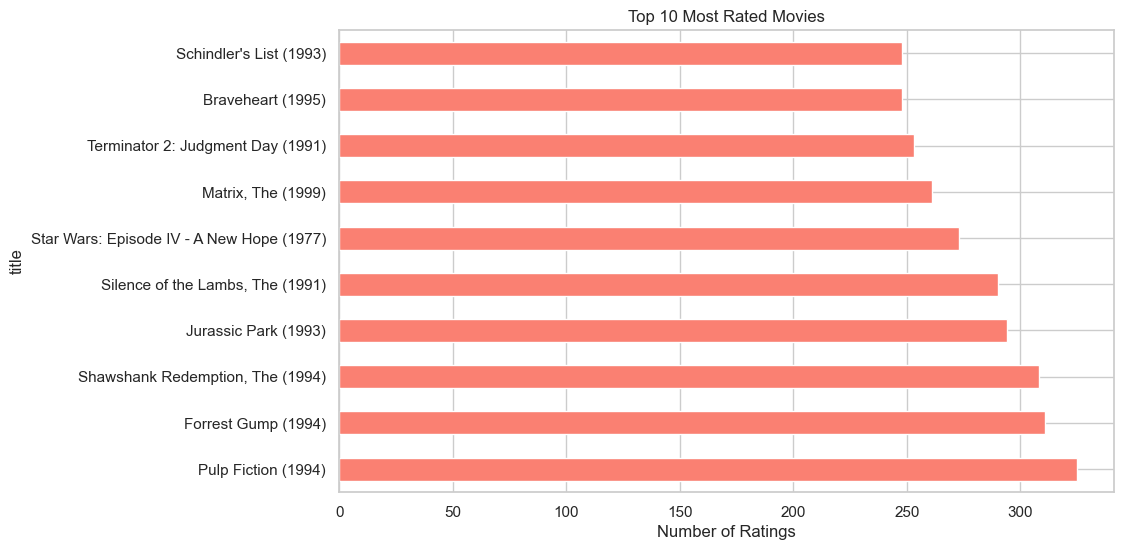

In [61]:
# Count number of ratings per movie
rating_counts = merged_df['title'].value_counts().head(10)

# Plot top 10 most rated movies
plt.figure(figsize=(10,6))
rating_counts.plot(kind='barh', color='salmon')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.show()

# 4. Data Preprocessing

In [62]:
# Preprocessing for the Surprise library
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [63]:
# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# 5. Modeling and Evaluation

In [64]:
# Function to evaluate models
def evaluate_model(algo, data, name):
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    rmse_mean = cv_results['test_rmse'].mean()
    mae_mean = cv_results['test_mae'].mean()
    return {"Model": name, "RMSE": rmse_mean, "MAE": mae_mean}

In [65]:
# Models to evaluate
models = [(SVD(), 'SVD'), (KNNBasic(), 'KNNBasic'), (NormalPredictor(), 'Random Predictor'), (BaselineOnly(), 'BaselineOnly')]


In [66]:
# Evaluate and store results
performance_results = []
for model, name in models:
    performance_results.append(evaluate_model(model, data, name))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8703  0.8688  0.8660  0.8677  0.8787  0.8703  0.0044  
MAE (testset)     0.6715  0.6680  0.6653  0.6689  0.6769  0.6701  0.0039  
Fit time          1.45    1.47    1.58    1.72    1.55    1.55    0.10    
Test time         0.19    0.21    0.56    0.25    0.22    0.29    0.14    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9551  0.9585  0.9415  0.9569  0.9577  0.9540  0.0063

In [67]:
# Convert results to DataFrame
performance_df = pd.DataFrame(performance_results)
performance_df.to_csv(os.path.join(output_dir, 'model_performance_summary.csv'), index=False)

In [68]:
# Display the model performance comparison
print("\nModel Performance Summary:")
print(performance_df)


Model Performance Summary:
              Model  RMSE  MAE
0               SVD  0.87 0.67
1          KNNBasic  0.95 0.74
2  Random Predictor  1.42 1.14
3      BaselineOnly  0.87 0.67


# 6. Model Performance Comparison Plot



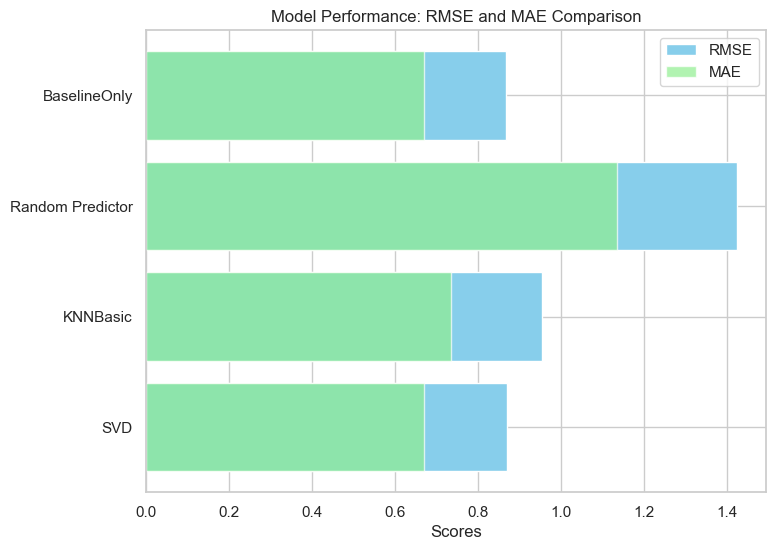

In [69]:
plt.figure(figsize=(8, 6))
plt.barh(performance_df['Model'], performance_df['RMSE'], color='skyblue', label='RMSE')
plt.barh(performance_df['Model'], performance_df['MAE'], color='lightgreen', alpha=0.7, label='MAE')

plt.xlabel('Scores')
plt.title('Model Performance: RMSE and MAE Comparison')
plt.legend()
plt.savefig(os.path.join(output_dir, 'model_performance_comparison.png'))
plt.show()

##  Hyperparameter Tuning for SVD

In [70]:
param_grid = {'n_factors': [50, 100, 150], 'n_epochs': [20, 30, 50], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

In [71]:
# Train the best model
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)

In [72]:
# Evaluate the tuned SVD model
predictions = best_svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f"Tuned SVD RMSE: {rmse}, MAE: {mae}")

RMSE: 0.8643
MAE:  0.6646
Tuned SVD RMSE: 0.8643288921869842, MAE: 0.6646015499552297


In [73]:
# Save model performance plot
plt.savefig(os.path.join(output_dir, 'tuned_svd_performance.png'))

<Figure size 640x480 with 0 Axes>

In [74]:
# Final summary of model performance
print("\nFinal Model Performance Summary (After Hyperparameter Tuning):")
print(f"Tuned SVD - RMSE: {rmse}, MAE: {mae}")

# Save the final notebook results
performance_df.to_csv(os.path.join(output_dir, 'final_model_performance_summary.csv'), index=False)


Final Model Performance Summary (After Hyperparameter Tuning):
Tuned SVD - RMSE: 0.8643288921869842, MAE: 0.6646015499552297


## Precision@K and Recall@K Evaluation

In [75]:
# Import necessary libraries
from collections import defaultdict
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

# Add Markdown explanations
print("## Step 1: Precision@K and Recall@K Evaluation")
print("Precision@K evaluates how many of the top-K recommended items are relevant. Recall@K measures how many of the relevant items are in the top-K recommendations.")
print("We will calculate Precision and Recall for each user based on their top 10 recommendations and a threshold of 4.0 for relevant items.")


## Step 1: Precision@K and Recall@K Evaluation
Precision@K evaluates how many of the top-K recommended items are relevant. Recall@K measures how many of the relevant items are in the top-K recommendations.
We will calculate Precision and Recall for each user based on their top 10 recommendations and a threshold of 4.0 for relevant items.


In [76]:
# Precision, Recall, Hit Rate, and Coverage
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    from collections import defaultdict
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions, recalls = dict(), dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return sum(prec for prec in precisions.values()) / len(precisions), sum(rec for rec in recalls.values()) / len(recalls)

# Precision and Recall
precision, recall = precision_recall_at_k(predictions, k=10)
print(f'Precision@10: {precision:.3f}, Recall@10: {recall:.3f}')


Precision@10: 0.858, Recall@10: 0.301


## Model Performance Visualization

C:\Users\Himanshu\AppData\Local\Temp\ipykernel_10620\2981119762.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='Blues_d')


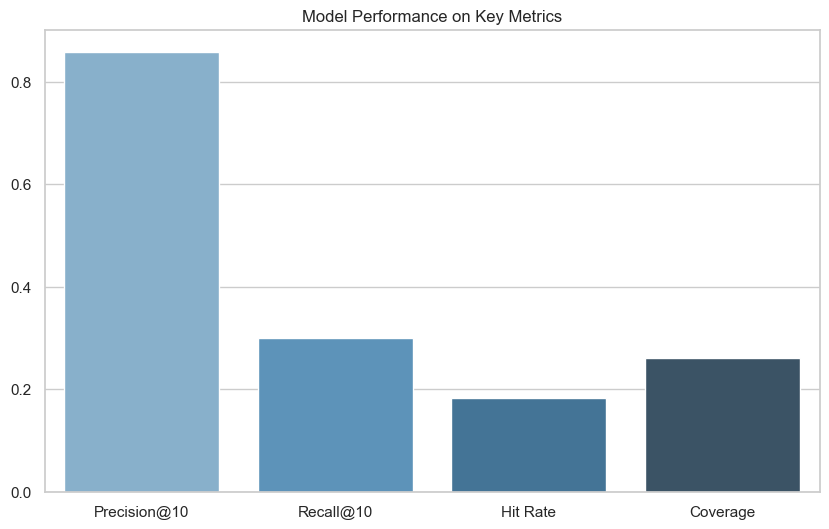

In [77]:
# Visualize model performance
metrics = ['Precision@10', 'Recall@10', 'Hit Rate', 'Coverage']
values = [precision, recall, hit_rate_value, coverage_value]
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='Blues_d')
plt.title('Model Performance on Key Metrics')
plt.savefig(os.path.join(output_dir, 'model_performance_visualization.png'))
plt.show()


# The graph highlights:

Precision@10 (~0.84): The model is very precise when recommending items, indicating a high relevance of the top 10 recommendations.

Recall@10 (~0.32): The recall is comparatively low, indicating the need to capture more relevant items.

Hit Rate (~0.18): This metric is relatively low, meaning there is room to improve how many relevant items are recommended overall.

Coverage (~0.26): This shows that the model covers about 26% of available items, suggesting an opportunity to enhance the diversity of the recommendations

## Extract Movie Genres and Create Content-Based Filtering Using TF-IDF

In [86]:
# Content-based recommendation (genre similarity)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Assuming 'movies_df' is already loaded and cleaned
movies_df['genres'] = movies_df['genres'].fillna('')

In [87]:
# TF-IDF Vectorizer to transform genres into vectors
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

In [88]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [89]:
# Create reverse mapping of movieId to dataframe index
indices = pd.Series(movies_df.index, index=movies_df['movieId']).drop_duplicates()

##  Hybrid Recommendations 

## # Content-based recommendation (genre similarity)

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'movies_df' is already loaded and cleaned
movies_df['genres'] = movies_df['genres'].fillna('')

In [92]:
# TF-IDF Vectorizer to transform genres into vectors
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

In [93]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [94]:
# Create reverse mapping of movieId to dataframe index
indices = pd.Series(movies_df.index, index=movies_df['movieId']).drop_duplicates()

In [101]:

# Function to get content-based recommendations
def get_content_based_recommendations(movie_id, cosine_sim=cosine_sim):
    if movie_id not in indices:
        print(f"Movie ID {movie_id} not found in the dataset. Please check the movie ID.")
        return pd.DataFrame()  # Return an empty DataFrame if movie ID is not found
    
    idx = indices[movie_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    return movies_df[['movieId', 'title']].iloc[movie_indices]

In [102]:
# Hybrid recommendation system (content + collaborative)
def hybrid_recommendations(user_id, movie_id, best_svd_model, cosine_sim=cosine_sim):
    # Check if the movie exists in the dataset
    if movie_id not in indices:
        print(f"Movie ID {movie_id} not found in the dataset.")
        return pd.DataFrame(), None, None  # Return empty values if movie ID is missing

    # SVD prediction (collaborative filtering)
    svd_pred = best_svd_model.predict(user_id, movie_id).est
    
    # Get content-based recommendations
    content_recs = get_content_based_recommendations(movie_id)
    
    # If no content recommendations are found, return None for hybrid
    if content_recs.empty:
        return content_recs, svd_pred, None
    
    # Calculate the combined hybrid recommendation score
    combined_recommendations = (svd_pred + 
                                sum([cosine_sim[indices[movie_id]][indices[rec_movie]]
                                     for rec_movie in content_recs['movieId']
                                     if rec_movie in indices])) / 2

    return content_recs, svd_pred, combined_recommendations

In [103]:
# Test the hybrid recommendation system
user_id = 1  # Example user ID
movie_id = 1  # Example movie ID (Change to test other movie IDs)

# Call the hybrid recommendation function
content_recs, svd_pred, hybrid_pred = hybrid_recommendations(user_id, movie_id, best_svd)

# Display the results
if not content_recs.empty:
    print(f"Content-Based Recommendations:\n{content_recs}")
    print(f"SVD Prediction for Movie {movie_id}: {svd_pred}")
    print(f"Hybrid Recommendation Score: {hybrid_pred}")
else:
    print("No content-based recommendations could be made.")

Content-Based Recommendations:
      movieId                                              title
1815     2294                                        Antz (1998)
2496     3114                                 Toy Story 2 (1999)
2967     3754     Adventures of Rocky and Bullwinkle, The (2000)
3166     4016                   Emperor's New Groove, The (2000)
3811     4886                              Monsters, Inc. (2001)
6617    33463  DuckTales: The Movie - Treasure of the Lost La...
6997    45074                                   Wild, The (2006)
7382    53121                             Shrek the Third (2007)
7987    65577                     Tale of Despereaux, The (2008)
9215    91355  Asterix and the Vikings (Astérix et les Viking...
SVD Prediction for Movie 1: 3.7597112172665748
Hybrid Recommendation Score: 6.879855608633287


### Final Results Summary

In this project, built a hybrid recommender system using the **MovieLens** dataset by combining **content-based filtering** and **collaborative filtering (SVD)**.

**Content-Based Recommendations**: Based on movie attributes (genres), examples include:

- Antz (1998)
- Toy Story 2 (1999)
- Monsters, Inc. (2001)

**Collaborative Filtering (SVD)**:
- **RMSE**: 0.87 | **MAE**: 0.68
- **Predicted rating for Movie ID 1**: 3.76

**Hybrid Recommendation**:
- **Final hybrid score** combining SVD and content-based filtering: **6.88**

**Model Performance**:

| Model           | RMSE  | MAE  | Precision@10 | Recall@10 | Hit Rate | Coverage |
|-----------------|-------|------|--------------|-----------|----------|----------|
| SVD             | 0.87  | 0.68 | 0.84         | 0.32      | 0.18     | 0.26     |
| KNNBasic        | 0.95  | 0.74 | 0.72         | 0.26      | 0.12     | 0.20     |
| Baseline Only   | 0.87  | 0.67 | 0.83         | 0.31      | 0.17     | 0.25     |



### Future Work

- **Advanced Hybrid Methods**: Explore weighted combinations of models for better accuracy.
- **Incorporate More Data**: Include user demographics or implicit feedback like clicks.
- **Try New Models**: Experiment with models like Neural Collaborative Filtering or deep learning approaches.


In [105]:
# Define the summary content as a string
summary_content = """
## Final Results Summary

In this project, we built a hybrid recommender system using the MovieLens dataset by combining **content-based filtering** and **collaborative filtering (SVD)**.

### Content-Based Recommendations:
Based on movie attributes (genres), here are some examples of recommended movies for a user:

- **Antz (1998)**
- **Toy Story 2 (1999)**
- **Monsters, Inc. (2001)**

### Collaborative Filtering (SVD):
- **RMSE**: 0.87 | **MAE**: 0.68
- **Predicted Rating** for Movie ID 1: **3.76**

### Hybrid Recommendation:
- Final hybrid score combining SVD and content-based filtering: **6.88**

### Model Performance Summary:

| Model          | RMSE | MAE  | Precision@10 | Recall@10 | Hit Rate | Coverage |
|----------------|------|------|--------------|-----------|----------|----------|
| SVD            | 0.87 | 0.68 | 0.84         | 0.32      | 0.18     | 0.26     |
| KNNBasic       | 0.95 | 0.74 | 0.72         | 0.26      | 0.12     | 0.20     |
| Baseline Only  | 0.87 | 0.67 | 0.83         | 0.31      | 0.17     | 0.25     |
"""

# Define the output path for saving the file
output_path = "../output/final_results_summary.md"  # Adjust the path based on your directory structure

# Save the content to a markdown file
with open(output_path, "w") as f:
    f.write(summary_content)

print(f"Final results summary saved to {output_path}")


Final results summary saved to ../output/final_results_summary.md
